<img style="margin-left:auto; margin-right:0px" src="./images/projet2-notebook-header.gif">

# 2 - Nettoyage des données

---

**Import des dépendances et des données**   
Le [fichier CSV](https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv) mise à disposition est d'une taille importante d'environ 3Go.  
Le fichier utilise l'encodage Unicode UTF-8. Le caractère de séparation des champs est <tab> (tabulation).   
Nous commençons donc par importer les librairies puis nous chargeons en mémoire les données.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

filenamePath = 'en.openfoodfacts.org.products.csv'
usecols = ['code','nutriscore_grade','proteins_100g','carbohydrates_100g','fat_100g','salt_100g']

dataframe = pd.read_csv(filenamePath, sep='\t', usecols=usecols)

C:\Users\adrie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Le chargement des données retourne un avertissement sur la présence de type différent dans la colonne 0.   
Ce n'est pas un probleme, le code-barres est en réalité une chaine de caractéres, car certains sont trop longs pour être stockés en type float64 par le systéme.

**Un premier regard**   
Je vais donc prendre connaissance du véritable contenu et de la qualité de mes données.

In [2]:
dataframe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486047 entries, 0 to 1486046
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   code                1486047 non-null  object 
 1   nutriscore_grade    591486 non-null   object 
 2   fat_100g            1186034 non-null  float64
 3   carbohydrates_100g  1185427 non-null  float64
 4   proteins_100g       1187175 non-null  float64
 5   salt_100g           1163266 non-null  float64
dtypes: float64(4), object(2)
memory usage: 68.0+ MB


In [3]:
dataframe.head(5)

,code,nutriscore_grade,fat_100g,carbohydrates_100g,proteins_100g,salt_100g
0,0000000000017,NaN,7.0,70.1,7.8,1.4
1,0000000000031,NaN,NaN,NaN,NaN,NaN
2,000000000003327986,NaN,NaN,NaN,NaN,NaN
3,0000000000100,d,8.2,29.0,5.1,4.6
4,00000000001111111111,NaN,NaN,NaN,NaN,NaN


Le premier regard nous indique la présence de valeurs manquantes.   
Nous nous devons de répondre à un certains nombres de questions avant de nettoyer ce jeu de données.   
Nous pouvons représenter notre jeu de données idéal.

<table style="margin:0px;">
    <thead>
    <tr>
        <td><b>nom des colonnes</b></td>
        <td><b>nom des colonnes (source)</b></td>
        <td><b>type des données</b></td>
        <td><b>type variables</b></td>
        <td><b>contraintes</b></td>
    </tr>
    </thead>
    <tr>
        <td>code</td>
        <td>code	</td>
        <td>object</td>
        <td>qualitative nominale</td>
        <td>clé unique</td>
    </tr>
    <tr>
        <td>nutriscore</td>
        <td>nutriscore_grade	</td>
        <td>object</td>
        <td>qualitative ordinale</td>
        <td>['a','b','c','d,'e']</td>
    </tr>
    <tr>
        <td>proteines</td>
        <td>proteins_100g	</td>
        <td>float64</td>
        <td>quantitative continue</td>
        <td>0&lt;x&lt;100</td>
    </tr>
    <tr>
        <td>glucides</td>
        <td>carbohydrates_100g	</td>
        <td>float64</td>
        <td>quantitative continue</td>
        <td>0&lt;x&lt;100</td>
    </tr>
    <tr>
        <td>lipides</td>
        <td>fat_100g</td>
        <td>float64</td>
        <td>quantitative continue</td>
        <td>0&lt;x&lt;100</td>
    </tr>
    <tr>
        <td>sels</td>
        <td>salt_100g</td>
        <td>float64</td>
        <td>quantitative numérique</td>
        <td>0&lt;x&lt;100</td>
    </tr>
</table>

**Transformation des noms de colonnes**

In [4]:
dataframe = dataframe.rename(
    columns={"code": "code",
             "nutriscore_grade":"nutriscore",
             "proteins_100g": "proteines",
             "carbohydrates_100g": "glucides",
             "fat_100g": "lipides",
             "salt_100g":"sels"})

**Suppression des doublons suivant la clé**   
Ma première approche consiste à identifier et à retirer les produits qui seraient en double.  
Vu que le code-barres est censé être unique, on va s'en servir comme identifiant.

In [5]:
dataframe2 = dataframe.drop_duplicates(subset='code')
number_deleted_rows = dataframe.shape[0] - dataframe2.shape[0]
print("On a supprimé {} lignes".format(number_deleted_rows)+" soit {:.2f}".format(number_deleted_rows/dataframe.shape[0]*100)+'%')

On a supprimé 326 lignes soit 0.02%


**Identification des valeurs manquantes**   

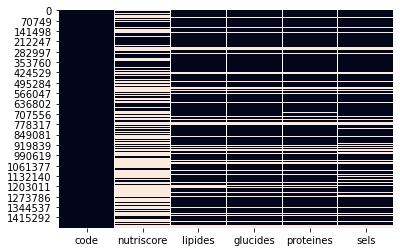

In [6]:
sns.heatmap(dataframe2.isnull(), cbar=False)

In [7]:
percentageNanbyColumns = dataframe2.isnull().sum(axis = 0) / dataframe2.shape[0] * 100.00
percentageNanbyColumns

code           0.000000
nutriscore    60.195286
lipides       20.189255
glucides      20.230043
proteines     20.112390
sels          21.721642
dtype: float64

Le pourcentage de valeurs manquantes reste faible pour nos nutriments.   
Le nutriscore étant la valeur TARGET, nous allons devoir supprimer les lignes n'ayant pas de valeur pour le Nutriscore.

In [8]:
dataframe3 = dataframe2.dropna(subset=['nutriscore'], axis='index')

In [9]:
percentageNanbyColumns = dataframe3.isnull().sum(axis = 0) / dataframe2.shape[0] * 100.00
percentageNanbyColumns

code          0.000000
nutriscore    0.000000
lipides       0.107759
glucides      0.125663
proteines     0.107826
sels          0.080567
dtype: float64

Nos valeurs d'input manquantes sont presques inexistantes.
Vu la taille importante du dataset nous décidons de ne pas garder les lignes qui ont une ou des valeurs de nutriments manquantes.

In [10]:
dataframe4 = dataframe3.dropna(axis='index')

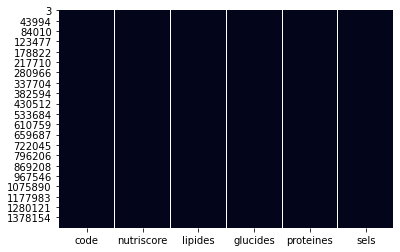

In [11]:
sns.heatmap(dataframe4.isnull(), cbar=False)

**Feature imputation**   
Aucune

**Vérification de l'intégrité et suppression des valeurs aberrantes**   
Les nutriments doivent être compris entre 0 et 100 grammes pour 100 grammes.

In [12]:
dataframe4.describe()

,lipides,glucides,proteines,sels
count,589457.000000,589457.000000,589457.000000,589457.000000
mean,14.360888,28.826305,8.344836,1.503708
std,17.703883,27.563704,9.107605,132.587554
min,0.000000,0.000000,0.000000,0.000000
25%,1.060000,4.500000,1.900000,0.100000
50%,8.000000,17.100000,6.000000,0.600000
75%,22.810000,53.570000,12.000000,1.320000
max,1233.000000,1390.000000,2000.000000,99500.000000


On peut voir que les 4 colonnes ont des valeurs abbérantes.
Ce n'est pas un probleme d'unité, nous les supprimons.

In [13]:
dataframe5 = dataframe4.query('lipides < 100 and glucides < 100 and proteines < 100 and sels < 100')

Nous vérifions qu'il y a bien que les 5 classes pour le Nutriscore.

In [14]:
dataframe5.nutriscore.unique()

array(['d', 'b', 'a', 'c', 'e'], dtype=object)

**Export pour analyse**

In [16]:
dataframe5.to_csv("en.openfoodfacts.org.products-df5.csv",index=False)